In [1]:
import os
import torch
import zipfile
from torch.utils.data import random_split

In [2]:
with zipfile.ZipFile("./Data_Set.zip", 'r') as zip:
    zip.extractall(path="./data")

In [3]:
data_path = "./data/Data Set"
print(os.listdir(data_path))
categories = os.listdir(data_path + "/train")
print(categories)

['.DS_Store', 'References used - Test', 'References Used Train', 'Train']
['Mask_Worn_Incorrectly', '.DS_Store', 'Surgical Mask', 'N95 Mask', 'No face Mask', 'Cloth Mask']


In [4]:
for category in categories:
    if category != '.DS_Store':
        print("# Train samples for {} are:".format(category), len(os.listdir(data_path + "/train/"+ category)))

# Train samples for Mask_Worn_Incorrectly are: 433
# Train samples for Surgical Mask are: 402
# Train samples for N95 Mask are: 400
# Train samples for No face Mask are: 400
# Train samples for Cloth Mask are: 400


In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [6]:
transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])
training_Data_Set = ImageFolder(data_path + "/train", transform=transforms)

In [7]:
image , label = training_Data_Set[0]
print(image.shape, label)
categories = training_Data_Set.classes
print(categories)

torch.Size([3, 128, 128]) 0
['Cloth Mask', 'Mask_Worn_Incorrectly', 'N95 Mask', 'No face Mask', 'Surgical Mask']


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def show_image(img, lab):
    print('Label: {}'.format(lab), training_Data_Set.classes[lab])
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0 Cloth Mask


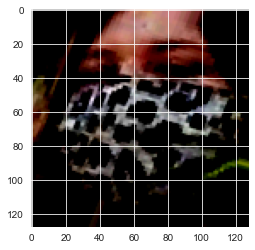

In [10]:
show_image(*training_Data_Set[100])

In [11]:
random_seed = 48
torch.manual_seed(random_seed)

In [12]:
test_size = int(len(training_Data_Set) * 0.25)
train_size = len(training_Data_Set) - test_size
train_data_set, test_data_set = random_split(training_Data_Set, [train_size, test_size])
print(len(train_data_set), len(test_data_set))

1522 507


In [13]:
from torch.utils.data.dataloader import DataLoader
batch_size=128

In [14]:
train_data_loader = DataLoader(train_data_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_data_loader = DataLoader(test_data_set, batch_size * 2, num_workers=4, pin_memory=True)

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


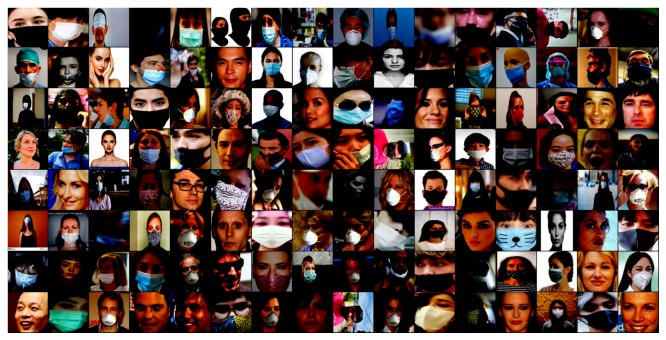

In [16]:
show_batch(train_data_loader)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class Face_Mask_CNN(nn.Module):

    def __init__(self, num_classes=3):
        super(Face_Mask_CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=28, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(in_channels=28, out_channels=36, kernel_size=3, stride=1, padding=1)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(in_channels=36, out_channels=40, kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(in_channels=40, out_channels=48, kernel_size=3, stride=1, padding=1)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(in_features=16 * 16 * 48, out_features=64)

        self.fc2 = nn.Linear(in_features=64, out_features=32)

        self.fc3 = nn.Linear(in_features=32, out_features=num_classes)

    def forward(self, x):

        x = F.relu(self.conv1(x))

        x = F.relu(self.pool1(self.conv2(x)))

        x = F.relu(self.conv3(x))

        x = F.relu(self.pool2(self.conv4(x)))

        x = F.relu(self.conv5(x))

        x = F.relu(self.pool3(self.conv6(x)))

        x = x.view(-1, 16 * 16 * 48)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return torch.log_softmax(x, dim=1)


if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

model1 = Face_Mask_CNN(num_classes= len(categories)).to(device)

print(model1)

Face_Mask_CNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(28, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(36, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(40, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12288, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)


In [38]:
class Face_Mask_CNN2(nn.Module):

    def __init__(self, num_classes=3):
        super(Face_Mask_CNN2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=28, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(in_channels=28, out_channels=36, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=36, out_channels=40, kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(in_channels=40, out_channels=48, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features= 64 * 64 * 48, out_features=num_classes)

    def forward(self, x):

        x = F.relu(self.pool1(self.conv1(x)))

        x = F.relu(self.conv2(x))

        x = F.relu(self.conv3(x))

        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))

        x = F.relu(self.conv6(x))

        x = x.view(-1, 64 * 64 * 48)

        x = self.fc1(x)

        return torch.log_softmax(x, dim=1)


if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

model2 = Face_Mask_CNN2(num_classes= len(categories)).to(device)

print(model2)

Face_Mask_CNN2(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(28, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(36, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(40, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=196608, out_features=5, bias=True)
)


In [52]:
class Face_Mask_CNN3(nn.Module):

    def __init__(self, num_classes=3):
        super(Face_Mask_CNN3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=46, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=46, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features= 64 * 64 * 64, out_features=num_classes)

    def forward(self, x):

        x = F.relu(self.pool1(self.conv1(x)))

        x = F.relu(self.conv2(x))

        x = F.relu(self.conv3(x))

        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))

        x = x.view(-1, 64 * 64 * 64)

        x = self.fc1(x)

        return torch.log_softmax(x, dim=1)


if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

model3 = Face_Mask_CNN3(num_classes= len(categories)).to(device)

print(model3)

Face_Mask_CNN3(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 46, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(46, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=262144, out_features=5, bias=True)
)


In [53]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = loss_criteria(output, target)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))

    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [54]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += loss_criteria(output, target).item()

            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return avg_loss

In [55]:
import torch.optim as optim
optimizer = optim.Adam(model3.parameters(), lr=0.00001, weight_decay=0.0001)

loss_criteria = nn.CrossEntropyLoss()

epoch_nums = []
training_loss = []
validation_loss = []

epochs = 40
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss = train(model3, device, train_data_loader, optimizer, epoch)
    test_loss = test(model3, device, test_data_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Training on mps
Epoch: 1
	Training batch 1 Loss: 1.609520
	Training batch 2 Loss: 1.606547
	Training batch 3 Loss: 1.618094
	Training batch 4 Loss: 1.608313
	Training batch 5 Loss: 1.623430
	Training batch 6 Loss: 1.608975
	Training batch 7 Loss: 1.607190
	Training batch 8 Loss: 1.603064
	Training batch 9 Loss: 1.611163
	Training batch 10 Loss: 1.613401
	Training batch 11 Loss: 1.606190
	Training batch 12 Loss: 1.605547
Training set: Average loss: 1.610120
Validation set: Average loss: 1.602466, Accuracy: 107/507 (21%)

Epoch: 2
	Training batch 1 Loss: 1.602469
	Training batch 2 Loss: 1.602839
	Training batch 3 Loss: 1.594193
	Training batch 4 Loss: 1.597412
	Training batch 5 Loss: 1.601948
	Training batch 6 Loss: 1.604653
	Training batch 7 Loss: 1.600031
	Training batch 8 Loss: 1.596642
	Training batch 9 Loss: 1.597825
	Training batch 10 Loss: 1.590479
	Training batch 11 Loss: 1.591259
	Training batch 12 Loss: 1.590168
Training set: Average loss: 1.597493
Validation set: Average loss:

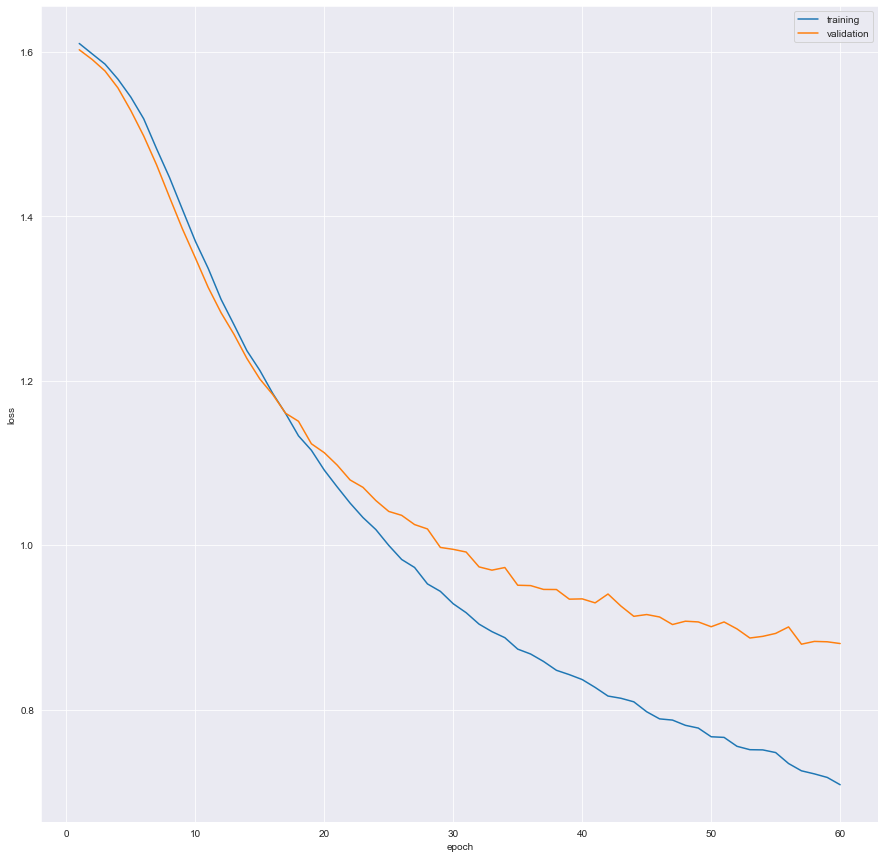

In [56]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig('./Results/loss_plot_'+ model3.__class__.__name__ + '_.pdf')
plt.show()

Getting predictions from test set...


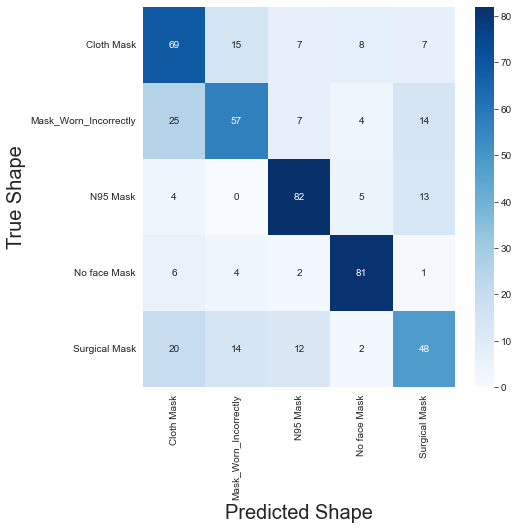

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

truelabels = []
predictions = []
model3.eval().to('cpu')
print("Getting predictions from test set...")
for data, target in test_data_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model3(data).data.numpy().argmax(1):
        predictions.append(prediction)

    # Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(categories))

df_cm = pd.DataFrame(cm, index = categories, columns = categories)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.savefig('./Results/confusion_matrix_'+ model3.__class__.__name__ + '.pdf')
plt.show()

In [58]:
from sklearn.metrics import classification_report
report = classification_report(truelabels, predictions, target_names= categories, output_dict=True)
print(report)
df = pd.DataFrame(report).transpose()
df.to_csv('./Results/Classification_Report_'+ model3.__class__.__name__ + '.csv')

{'Cloth Mask': {'precision': 0.5564516129032258, 'recall': 0.6509433962264151, 'f1-score': 0.6, 'support': 106}, 'Mask_Worn_Incorrectly': {'precision': 0.6333333333333333, 'recall': 0.5327102803738317, 'f1-score': 0.5786802030456852, 'support': 107}, 'N95 Mask': {'precision': 0.7454545454545455, 'recall': 0.7884615384615384, 'f1-score': 0.766355140186916, 'support': 104}, 'No face Mask': {'precision': 0.81, 'recall': 0.8617021276595744, 'f1-score': 0.8350515463917526, 'support': 94}, 'Surgical Mask': {'precision': 0.5783132530120482, 'recall': 0.5, 'f1-score': 0.536312849162011, 'support': 96}, 'accuracy': 0.6646942800788954, 'macro avg': {'precision': 0.6647105489406305, 'recall': 0.6667634685442719, 'f1-score': 0.663279947757273, 'support': 507}, 'weighted avg': {'precision': 0.6625954292915937, 'recall': 0.6646942800788954, 'f1-score': 0.6611451581572099, 'support': 507}}


In [59]:
torch.save(model3.state_dict(), 'saved_model.pth')